In [377]:
import json
import pandas as pd
from numpy import array

import torch
import torch.nn
import torch.optim as optim

# Used in LTSMModel Class Instantiation
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


Found 34 tensors with length 0 at indices: [810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 2460, 2501, 2512, 2583, 5414, 5415, 5416, 5417, 5418, 5419, 5420, 5421, 5422, 5423]


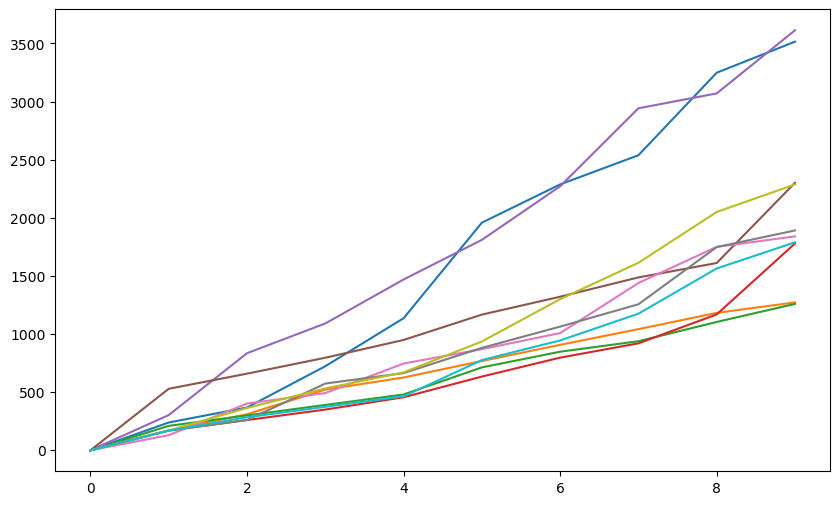

In [378]:
%run data_prep_one_hero.ipynb

In [379]:
#df_allhero[['gold_t']]

#df_allhero[['gold_t']] = 

In [380]:
len(df_allhero.iloc[0]['gold_t'])

53

### TimeSeriesDataset Class

In [381]:
type(df_allhero[['gold_t']])

pandas.core.frame.DataFrame

In [382]:
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    # Class to create our dataset
    def __init__(self, df, lookback):
        self.hero_ids = df['hero_id'].values # Declaring hero_id values
        self.time_series = df[['gold_t']]
        #[torch.tensor(ts) for ts in df['gold_t']] # Converting the time_series into Tensors
        self.max_length = max(len(ts) for ts in self.time_series) # Grabs max length of all the tensors to pad them with 0s later
        self.match_ids = df['match_id'] #Storing the match_id in case we want to view this later for more info
        self.lookback = lookback


    def __len__(self):
        return len(self.hero_ids) # Convenient length call
    

    def create_windows(self, timeseries):
        X, y = [], []
        for i in range(len(timeseries) - self.lookback):
            feature = timeseries[i:i+self.lookback]
            target = timeseries[i+1:i+self.lookback+1]
            X.append(feature)
            y.append(target)


        print("Create Window X Obj:",X)
        print("Create Window y Obj:",y)
        print("Create Window Type X:", type(X))
        print("Create Window Type y:", type(y))
        #print(len(X))
        #print(len(y))
        
        X = torch.tensor(X)
        y = torch.tensor(y)
        return X, y
    
    

    def __getitem__(self, idx):
        print("1st Step __getitem__ State: ", idx)
        hero_id = self.hero_ids[idx]
        time_series = np.array(self.time_series.iloc[idx][0]).astype('float32') # Since the df_allhero 'gold_t' column is a column of lists, we take the 
        #first row of the df_allhero with .iloc[idx]
        # then we access the the first element of the row, which is the list, with [0]
        # we convert it to a numpy array, and then convert values to float32 
        # we do this to be compatible with the ConstantMinMaxScaler()
        
        match_id = self.match_ids[idx]


        
        scaled_time_series = ConstantMinMaxScaler(time_series, min_gold, max_gold)
        print("Type of scaled_time_series:",type(scaled_time_series))
        length = len(scaled_time_series)

        X, y = self.create_windows(scaled_time_series)
        #print(X.shape, y.shape)
        print("Post create_window:",idx)
        print("Type of X", type(X))
        print("Type of y", type(y))
        


        return hero_id, X, y
 


### Embedding Layer

In [383]:
import torch
import torch.nn as nn

class ProcessEmbedding(nn.Module):
    def __init__(self, df, embedding_dim, lookback):
        super(ProcessEmbedding, self).__init__() 

        self.num_processes = len(df['hero_id'].unique()) # declaring number of different categories of time-series for dimensionialty reasons
        self.embedding_dim = embedding_dim # passing our embed size to be a class attribute
        self.process_embeddings = nn.Embedding(self.num_processes, embedding_dim)

        self.hero_id_to_idx = {hero_id: idx for idx, hero_id in enumerate(df['hero_id'].unique())}

        

    def forward(self, hero_ids):

        process_ids = [self.hero_id_to_idx[hero_id.item()] for hero_id in hero_ids]
        process_ids = torch.tensor(process_ids)
        process_embeddings = self.process_embeddings.unsqueeze(1).repeat(1, self.lookback, 1)

        print("Process Embeddings shape:", process_embeddings.shape)
        print("Process Embeddings tensor:", process_embeddings)

        return process_embeddings


### LSTM

In [384]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, process_embedding):
        super(LSTMModel, self).__init__() # ensures the correcty PyTorch class is also initialized

        self.hidden_size = hidden_size #hyper param 
        self.num_layers = num_layers #hyper param

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # Actual LSTM creation
        self.fc = nn.Linear(hidden_size, output_size) # Linear Model creation
        self.process_embedding = process_embedding # Process Embedding


    def forward(self, batch):
        print("LSTM Forward Method Batch Type: ",type(batch))
        # Since our Dataset class returns 3 objects, hero_id, X, y and the forward method only expects two, we have to 
        #    tell our forward method to expect one object and unpack it
        hero_ids = batch[0][0] # the _ is a placeholder that doesn't save the last object in the batch which is the y tensor
        X = batch[1][0]
        print("LSTM Forward Method X Type: ",type(X))
        print("LSTM Forward Method hero_ids Type: ",type(hero_ids))
        print(X)
        print(hero_ids)
        batch_size = X.size(0) # pulling dims from the tensor
        seq_length = X.size(1) # pulling dims from the tensor
        
        # Get process embeddings for hero_ids
        process_embeddings = self.process_embedding(hero_ids)

        print("Process Embeddings shape:", process_embeddings.shape)
        print("Time Series shape:", X.shape)
        
        # Reshape process embeddings to match the input shape of LSTM
        # process_embeddings = process_embeddings.unsqueeze(1).repeat(1, seq_length, 1)

        # dim = -1, signifies concatenation across the last dimension (the feature dimension)
        combined_input = torch.cat((X,process_embeddings),dim=-1) #

        print("Concat'd Time-Series + Embedding shape:", combined_input.shape)

        # Unsqueexing to ensure the time_series shape is 3D like our embedding processing is so that no issues are ran into with torch.cat below
        #time_series = time_series.unsqueeze(-1)

        #print("Time Series shape with extra dimension:", time_series.shape)
        
        # Concatenate process embeddings with time series data
        
        
        
        # Pack the padded sequences
        # Packing the padded Sequences is a way of optimizing computation times. We have padded the time series to all be the same length, even though some are only 20 or less
        # The packing indicates which are the real values in the time series so that the computation is only ran on those time steps. Details on how are unknown to me thus far.
        #packed_input = pack_padded_sequence(input_data, lengths, batch_first=True, enforce_sorted=False)


        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        

        #packed_output, _ = self.lstm(packed_input, (h0, c0))

        # Unpack the output
        #output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Pass combined input to LSTM layer
        output, _ = self.lstm(combined_input)

        # Take the last output of the LSTM
        out = self.fc(output[:, -1, :])
        
        return out

### Instantiating Classes and Parameters

In [385]:
lookback = 10
#train_dataset = TimeSeriesDataset(df_allhero, lookback)
process_embedding = ProcessEmbedding(df_allhero, embedding_dim=84, lookback=lookback) # we create the embedding vector on unsplit data to ensure all unique hero id's are contained

input_size = process_embedding.embedding_dim + 1 #84 + 1
hidden_size = 64
num_layers = 2
output_size = 1  # Assuming you want to predict a single value

model = LSTMModel(input_size, hidden_size, num_layers, output_size, process_embedding)

### Train Test Split

In [386]:
# test_size = .30

# train_df, test_df = train_test_split(df_full, test_size=test_size, shuffle=False)



#### Dataset and Data Load

In [387]:
batch_size = 1

train_dataset = TimeSeriesDataset(df_allhero, lookback=lookback)
test_dataset = TimeSeriesDataset(df_allhero_avglen, lookback=lookback)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
# train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_dataset), batch_size=batch_size, shuffle=False)
# test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_dataset), batch_size=batch_size, shuffle=False)


In [388]:
len(df_allhero.iloc[32]['gold_t'])

53

In [389]:
# # Iterate over the train_loader until the desired index
# for idx, (hero_ids, X, y) in enumerate(train_loader):
#     print(idx)
#     if idx == 32:
#         print('Gottem')
#         break

In [390]:
# Training loop
num_epochs = 500


# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(num_epochs):
    model.train()
    
    train_loss = 0.0
    print(f"Epoch: {epoch}")

    for batch in train_loader: #for hero_ids, X, y in train_loader:
    
        hero_ids, X, y = batch #outputs = model(hero_ids, X)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch)
        
        targets = y[:, -1, :]  # Assuming you want to predict the last value of each time series
        loss = criterion(outputs.squeeze(), targets.squeeze())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X.size(0)

    train_loss /= len(train_dataset)

    model.eval()
    test_loss = 0.0

    with torch.no_grad():
         for batch in test_loader: #for hero_ids, X, y in test_loader:
            # Forward pass
            hero_ids, X, y = batch
            outputs = model(batch) # outputs = model(hero_ids, X)
            targets = y[:, -1, :]  # Assuming you want to predict the last value of each time series
            loss = criterion(outputs.squeeze(), targets.squeeze())

            test_loss += loss.item() * X.size(0)

    test_loss /= len(test_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch: 0
1st Step __getitem__ State:  0
<class 'numpy.ndarray'>
Type of scaled_time_series: <class 'numpy.ndarray'>
Create Window X Obj: [array([0.00057577, 0.0029556 , 0.00592079, 0.00933701, 0.01382798,
       0.01614064, 0.01853967, 0.02126496, 0.0246044 , 0.03121611],
      dtype=float32), array([0.0029556 , 0.00592079, 0.00933701, 0.01382798, 0.01614064,
       0.01853967, 0.02126496, 0.0246044 , 0.03121611, 0.03574547],
      dtype=float32), array([0.00592079, 0.00933701, 0.01382798, 0.01614064, 0.01853967,
       0.02126496, 0.0246044 , 0.03121611, 0.03574547, 0.04249153],
      dtype=float32), array([0.00933701, 0.01382798, 0.01614064, 0.01853967, 0.02126496,
       0.0246044 , 0.03121611, 0.03574547, 0.04249153, 0.04781737],
      dtype=float32), array([0.01382798, 0.01614064, 0.01853967, 0.02126496, 0.0246044 ,
       0.03121611, 0.03574547, 0.04249153, 0.04781737, 0.05460181],
      dtype=float32), array([0.01614064, 0.01853967, 0.02126496, 0.0246044 , 0.03121611,
       0.0

TypeError: 'numpy.int64' object is not iterable

In [ ]:
type(df_allhero[['gold_t']].iloc[0][0])
#type(df_allhero[['gold_t']].iloc[0])

test = np.array(df_allhero[['gold_t']].iloc[0][0]).astype('float32')
test

array([   60.,   308.,   617.,   973.,  1441.,  1682.,  1932.,  2216.,
        2564.,  3253.,  3725.,  4428.,  4983.,  5690.,  6254.,  6719.,
        7783.,  8712.,  9511., 10152., 11513., 12799., 13099., 14139.,
       15065., 16329., 17442., 17537., 17970., 19225., 19895., 21110.,
       22862., 24019., 24889., 25690., 26233., 26897., 28101., 28775.,
       29870., 31472., 33097., 33932., 35939., 37105., 37211., 38548.,
       39935., 42104., 43058., 44358., 44652.], dtype=float32)

In [ ]:
test = pd.DataFrame(df_allhero[['gold_t']].iloc[0])
test

0
gold_t  [60, 308, 617, 973, 1441, 1682, 1932, 2216, 25...